In [1]:
import hyperopt
print("hyperopt.__version__", hyperopt.__version__)
import sklearn
print("sklearn.__version__", sklearn.__version__)
#pip install scikit-learn==1.0.2  다운그레이드 해서 테스트하기
import pandas
print("pandas.__version__", pandas.__version__)
#pip install pandas==1.3.5
import xgboost
print("xgboost.__version__", xgboost.__version__)

hyperopt.__version__ 0.2.7
sklearn.__version__ 1.0.2
pandas.__version__ 1.3.5
xgboost.__version__ 1.5.0


In [7]:
import pandas as pd
import numpy as np

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [8]:
cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [11]:
#개별 모델 : 로지스틱 회귀 , KNN
lr_clf = LogisticRegression(solver= 'liblinear')
knn_clf = KNeighborsClassifier(n_neighbors= 8 )

#개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf )],
                 voting= 'soft' #mean
                 )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size= 0.2, random_state= 156)

#VotingClassifier 학습/예측 평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('정확도 : ',np.round(accuracy_score(y_test, pred),4))


정확도 :  0.9561


In [12]:
# 1. 개별 분류기 예측 성능 : LR
lr_clf_1 = LogisticRegression(solver = 'liblinear')
lr_clf_1.fit(X_train, y_train)
pred = lr_clf_1.predict(X_test)
print('정확도 : ',np.round(accuracy_score(y_test, pred),4))

정확도 :  0.9474


In [15]:
# 2. 개별 분류기 예측 성능 : KNN
knn_clf_1 = KNeighborsClassifier(n_neighbors= 8)
knn_clf_1.fit(X_train, y_train)
pred = knn_clf_1.predict(X_test)
print('정확도 : ',np.round(accuracy_score(y_test, pred),2))

정확도 :  0.94


/Users/pakeunseo/opt/anaconda3/envs/xgboost_env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## GBM(Gradient Boosting Machine)

In [18]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [19]:
def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./data/UCI HAR Dataset/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./data/UCI HAR Dataset/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./data/UCI HAR Dataset/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./data/UCI HAR Dataset/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./data/UCI HAR Dataset/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

start_time = time.time() #수행시간 측정

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
print('GBM 정확도 : ',np.round(accuracy_score(y_test, gb_pred),2))
print('GBM 수행시간 : {0:.1f}초'.format(time.time()-start_time))

GBM 정확도 :  0.94
GBM 수행시간 : 472.2초


## XGBoost(eXtra Gradient Boost)

In [29]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

In [53]:
df = pd.DataFrame(data = X_features, columns= dataset.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [57]:
#1 -> 양성 benign 357개, 2 -> 악성 malignant 212개
print(dataset.target_names)
df['target'] = y_label
df['target'].value_counts()

['malignant' 'benign']


1    357
0    212
Name: target, dtype: int64

In [30]:
#1. Python native XGBoost

In [35]:
X_featrues = df.iloc[:,:-1]
y_label = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state= 156)
X_tr, X_val, y_tr, y_val = train_test_split(X_features, y_label, test_size=0.1, random_state= 156)

#학습, 검증, 테스트용 DMatrix 생성
dtr = xgb.DMatrix(data = X_tr, label = y_tr)
dval = xgb.DMatrix(data = X_val, label = y_val)
dtest = xgb.DMatrix(data = X_test, label = y_test)

In [36]:
#XGB 파라미터 생성 
params = {
    'max_depth':3,
    'eta':0.05, #learning rate 
    'objective':'binary:logistic', #이진 분류 (0,1)
    'eval_metric':'logloss' #오류 함수 평가 성능 지표 
}

num_rounds = 400 #부스팅 반복 횟수 


In [39]:
eval_list = [(dtr,'train'),(dval,'eval')]
xgb_model= xgb.train(params = params, dtrain = dtr , num_boost_round = num_rounds, \
          early_stopping_rounds= 50, evals= eval_list)

[0]	train-logloss:0.65072	eval-logloss:0.65622
[1]	train-logloss:0.61220	eval-logloss:0.62291
[2]	train-logloss:0.57711	eval-logloss:0.59275
[3]	train-logloss:0.54501	eval-logloss:0.56534
[4]	train-logloss:0.51561	eval-logloss:0.53837
[5]	train-logloss:0.48841	eval-logloss:0.51541
[6]	train-logloss:0.46337	eval-logloss:0.49320
[7]	train-logloss:0.43886	eval-logloss:0.47140
[8]	train-logloss:0.41719	eval-logloss:0.45388
[9]	train-logloss:0.39660	eval-logloss:0.43685
[10]	train-logloss:0.37748	eval-logloss:0.41992
[11]	train-logloss:0.35954	eval-logloss:0.40570
[12]	train-logloss:0.34310	eval-logloss:0.39243
[13]	train-logloss:0.32686	eval-logloss:0.37818
[14]	train-logloss:0.31212	eval-logloss:0.36699
[15]	train-logloss:0.29837	eval-logloss:0.35300
[16]	train-logloss:0.28516	eval-logloss:0.34148
[17]	train-logloss:0.27248	eval-logloss:0.33051
[18]	train-logloss:0.26081	eval-logloss:0.32049
[19]	train-logloss:0.24956	eval-logloss:0.31034
[20]	train-logloss:0.23922	eval-logloss:0.30161
[2

In [40]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정

preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

[0.852 0.002 0.75  0.156 0.994 1.    1.    0.999 0.996 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_probs=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)

    print('오차행렬:\n',confusion)
    print('*'*20)
    print(f'정확도:{accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

In [72]:
get_clf_eval(y_test,preds,pred_probs)

오차행렬:
 [[36  1]
 [ 1 76]]
********************
정확도:0.9825, 정밀도: 0.9870, 재현율: 0.9870, F1: 0.9870, AUC: 0.9800


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

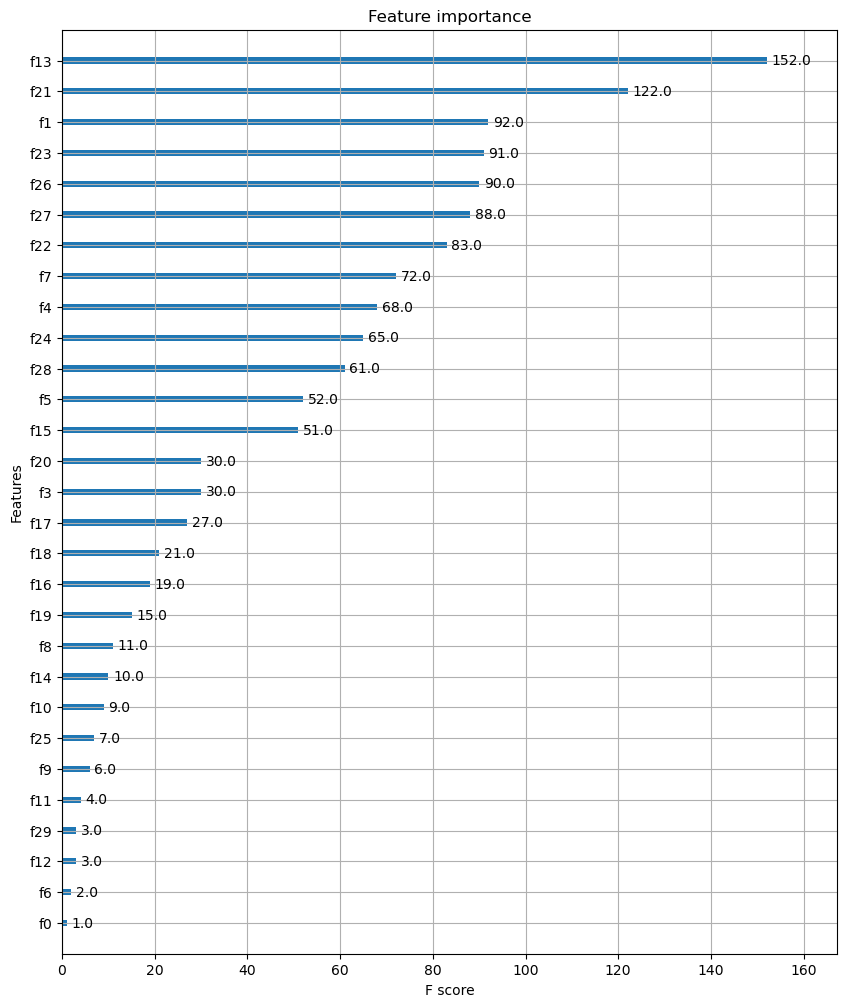

In [63]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

%matplotlib inline

fig,ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_model, ax=ax)

In [62]:
#2. sklearn.xgboost

In [ ]:
params = {
    'max_depth':3,
    'eta':0.05, #learning rate 
    'objective':'binary:logistic', #이진 분류 (0,1)
    'eval_metric':'logloss' #오류 함수 평가 성능 지표 
}

In [65]:
from xgboost import XGBClassifier

xgb_wrapper_model = XGBClassifier(n_estimators = 400,
                                  learning_rate = 0.05,
                                  max_depth =3,
                                  eval_metric ='logloss')
xgb_wrapper_model.fit(X_train, y_train, verbose= True)
wr_pred = xgb_wrapper_model.predict(X_test)
wr_pred_proba = xgb_wrapper_model.predict_proba(X_test)[:,1]

In [74]:
get_clf_eval(y_test, wr_pred, wr_pred_proba)

오차행렬:
 [[34  3]
 [ 1 76]]
********************
정확도:0.9649, 정밀도: 0.9620, 재현율: 0.9870, F1: 0.9744, AUC: 0.9530
